In [1]:
import glob
import os, sys
import inspect
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 

import torch
import torch.nn as nn
import pandas
import numpy as np
import numpy.ma as ma
import pickle
import time

import proplot as pplt
import seaborn as sns
import sklearn
import re 
from fractions import Fraction
import scipy.stats as st

label_size = 12
pplt.rc['tick.labelsize'] = label_size 
pplt.rc['axes.labelsize'] = label_size + 3
sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 5})

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
from utils import *
from plotting_functions import *

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load model
exp_list = glob.glob(currentdir+"\\experiments\\poisson_clicks\\perfect_model\\exp*8288") #01 #92#51, list experiment folders
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))
exp_path = exp_list[-1]
idx = exp_path[-10:]
exp_path

with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)

training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'


rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
# rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu', constrain_spectrum=training_kwargs['constrain_spectrum']).to(device)
rnn_model = load_model(rnn_model, training_kwargs).to(device)

C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\perfect_model\exp_Nrec30_1667838288\weights1667838288.pth


In [3]:
weights_dict = {key: pandas.DataFrame(rnn_model.state_dict()[key]) for key in rnn_model.state_dict().keys()}
W_hh = rnn_model.state_dict()['rnn.weight_hh_l0'] 
W_ih = weights_dict['rnn.weight_ih_l0'] 
b_h = weights_dict['rnn.bias_hh_l0']
b_in = weights_dict['rnn.bias_ih_l0']


b = b_in + b_h
b = b[0].to_numpy()
W_hh = W_hh.numpy()
W_ih = W_ih.to_numpy()

I = np.array([0.,0.,0.,0.])


In [5]:
fun = partial(relu_step_input, W=W_hh, b=b, W_ih=W_ih, I=I)
fun = partial(relu_step, W=W_hh, b=b)
fxd_pnts = find_fixed_points_grid(fun,  training_kwargs['N_rec'], max_grid=1, step=1, tol = 10**-4,  maxiter = 10000,
                      method='Nelder-Mead', verbose=False)

In [6]:
fxd_pnts

array([], dtype=float64)

In [31]:
N_rec = training_kwargs['N_rec']
x0 = np.random.random(N_rec)*10
opt = minimize(
            lambda x: np.linalg.norm(fun(x) - x),
            x0=x0,
            method='Nelder-Mead',
            constraints=None, 
            bounds=[(0., np.Inf)],
            tol=1e-4,
            callback=None,
            options={})
fxd_pnt = opt.x
np.linalg.norm(fun(fxd_pnt) - fxd_pnt)

6.6790063102028645

In [37]:
def find_fixed_points_random(fun, Nrec, low=0.0, high=1.0, n_starts=100, tol = 10**-4,  maxiter = 10000,
                      method='Nelder-Mead', verbose=False, bounds=None):
    options = {"disp": verbose, "maxiter": maxiter}
    
    #create starting points to start search
    x_inits = np.random.uniform(low=low, high=high, size=(n_starts, Nrec))

    # constraint = {LinearConstraint([1], [-tol], [tol])} #use contraint to find real fixed point, not just minimum
    if bounds:
        bounds = [(0., np.Inf)]
    results = []
    for x0 in x_inits:
        opt = minimize(
            lambda x: np.linalg.norm(fun(x) - x),
            x0=x0,
            method=method,
            constraints=None, 
            bounds=bounds,
            tol=tol,
            callback=None,
            options=options)
        if opt.success:
            results.append(opt.x)

    results = np.array(results)
    return results

In [41]:
fxd_pnts = find_fixed_points_random(fun, training_kwargs['N_rec'], low=0.0, high=5.0, n_starts=100, tol = 10**-5,  maxiter = 10000,
                      method='CG', verbose=False)

In [42]:

velocities = []
for fxd_pnt in fxd_pnts:
    q = np.linalg.norm(relu_step(fxd_pnt, W=W_hh, b=b)-fxd_pnt)
    print(q)
    velocities.append(q)

8.513018802650932e-06
1.3937240620685922e-06
1.3937361080547204e-06
1.5612686479408462e-06
8.517095965371061e-06


(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([1.39372406e-06, 2.10606125e-06, 2.81839844e-06, 3.53073563e-06,
        4.24307282e-06, 4.95541001e-06, 5.66774720e-06, 6.38008439e-06,
        7.09242158e-06, 7.80475878e-06, 8.51709597e-06]),
 <BarContainer object of 10 artists>)

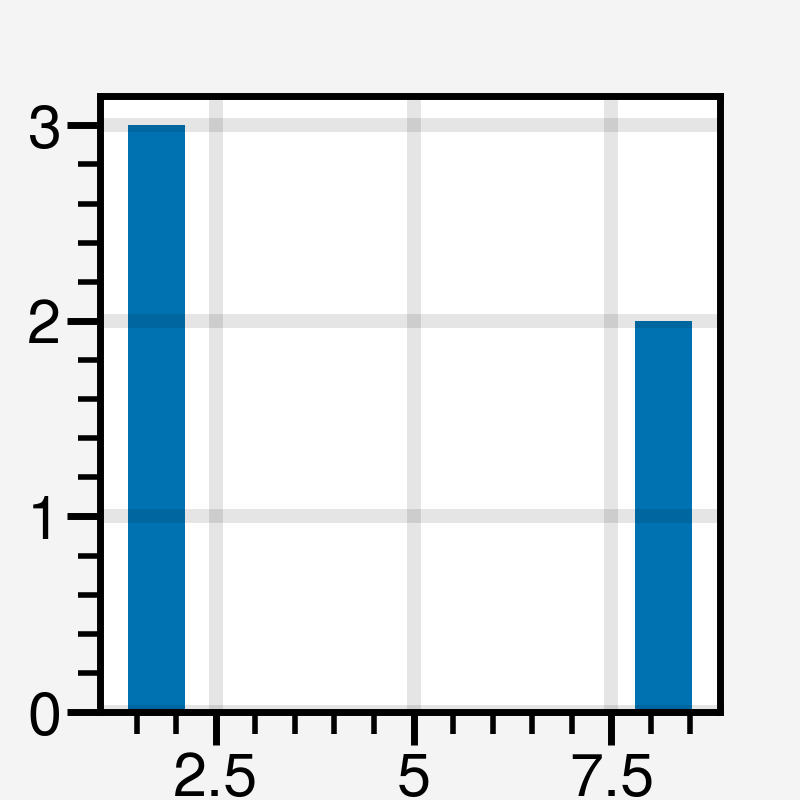

In [43]:
plt.hist(velocities)

In [44]:
fxd_pnts

array([[ 1.50968715e+00,  3.48110602e-07,  2.68083493e-07,
         2.66276948e+00,  7.32741484e+00, -1.45411033e-07,
         4.29140587e+00,  1.85105353e-07,  4.08622534e-01,
         1.95277806e-06,  3.59589549e+00,  7.94537546e+00,
         3.69869843e+00,  5.89289425e-01,  5.46020818e+00,
         1.28722254e+00, -1.30640814e-07, -3.28385099e-07,
        -3.24883230e-07,  1.58445772e+00,  3.52016800e-01,
         2.60807038e+00,  5.28795042e+00, -2.02359421e-06,
         3.35996440e+00,  1.06549240e-07,  1.08998335e-01,
        -1.33118744e-06,  2.41017556e-06,  5.47110660e+00],
       [ 6.05840708e-07,  1.81044147e+00,  6.49672183e-08,
         2.44501550e-07,  5.41735274e-01,  6.74818229e-01,
         3.37674354e+00,  1.52956847e+00,  4.73534652e-01,
         1.70937025e+00,  5.87054587e-01,  3.80062536e-08,
         2.62634894e-07,  3.02747409e+00,  5.56941056e-01,
         1.53161039e+00, -1.06757171e-07, -3.36361527e-08,
         2.61850271e-07,  3.07868113e+00,  4.34953392e-